# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Exercise-6.1.-Implementing-sigmoidal-Least-Squares-cost" data-toc-modified-id="Exercise-6.1.-Implementing-sigmoidal-Least-Squares-cost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exercise 6.1. Implementing sigmoidal Least Squares cost</a></div><div class="lev1 toc-item"><a href="#Exercise-6.3.-Implementing-the-Cross-Entropy-cost" data-toc-modified-id="Exercise-6.3.-Implementing-the-Cross-Entropy-cost-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercise 6.3. Implementing the Cross Entropy cost</a></div><div class="lev1 toc-item"><a href="#Exercise-6.7.-Implementing-the-Softmax-cost" data-toc-modified-id="Exercise-6.7.-Implementing-the-Softmax-cost-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercise 6.7. Implementing the Softmax cost</a></div><div class="lev1 toc-item"><a href="#Exercise-6.8.-Implementing-the-Log-Error-version-of-Softmax" data-toc-modified-id="Exercise-6.8.-Implementing-the-Log-Error-version-of-Softmax-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercise 6.8. Implementing the Log Error version of Softmax</a></div><div class="lev1 toc-item"><a href="#Exercise-6.9.-Using-gradient-descent-to-minimize-the-Perceptron-cost" data-toc-modified-id="Exercise-6.9.-Using-gradient-descent-to-minimize-the-Perceptron-cost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exercise 6.9. Using gradient descent to minimize the Perceptron cost</a></div><div class="lev1 toc-item"><a href="#Exercise-6.13.-Compare-the-efficacy-of-two-class-cost-functions-I" data-toc-modified-id="Exercise-6.13.-Compare-the-efficacy-of-two-class-cost-functions-I-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exercise 6.13. Compare the efficacy of two-class cost functions I</a></div><div class="lev1 toc-item"><a href="#Exercise-6.14.-Compare-the-efficacy-of-two-class-cost-functions-II" data-toc-modified-id="Exercise-6.14.-Compare-the-efficacy-of-two-class-cost-functions-II-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Exercise 6.14. Compare the efficacy of two-class cost functions II</a></div><div class="lev1 toc-item"><a href="#Exercise-6.15.-Credit-check" data-toc-modified-id="Exercise-6.15.-Credit-check-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Exercise 6.15. Credit check</a></div><div class="lev1 toc-item"><a href="#Exercise-6.16.-Weighted-classification-and-balanced-accuracy" data-toc-modified-id="Exercise-6.16.-Weighted-classification-and-balanced-accuracy-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Exercise 6.16. Weighted classification and balanced accuracy</a></div>

In [ ]:
%pip install mpmath

In [1]:
# import autograd-wrapped numpy
import autograd.numpy as np
from jax import grad, hessian
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import mpmath


mpmath.mp.dps = 50
jax.config.update("jax_enable_x64", True)

# datapath to data
datapath = '../mlrefined_datasets/superlearn_datasets/'



class LinearReg:

    def __init__(self, X, Y, w0):
        self.X = np.column_stack((np.ones(len(X.T)), X.T)).astype(np.float64)
        self.Y = Y.astype(np.float64)
        self.w0 = jnp.array(w0, dtype=jnp.float64)
        self.w, self.w_history, self.method, self.loss = None, None, None, None
        

    
    def linear_model(self, x, w):
        return jnp.dot(x, w.T)

    def RMS(self, w):
        return jnp.mean((self.linear_model(jnp.stack(self.X), w) - self.Y)**2)
        
    def MAD(self, w):
        return jnp.mean(abs(self.linear_model(jnp.stack(self.X), w) - self.Y))

    def set_function_loss(self, fun):
        if fun == "RMS":
            self.method, self.loss = self.RMS, self.RMS
        elif fun == "MAD":
            self.method, self.loss = self.MAD, self.MAD
        else:
            raise TypeError("Invalid loss function specified")

    @staticmethod
    def build_history_of_loss(i, fun_list, method_name):
            k = np.linspace(0, i, i+1)
            fun_arr = np.array(fun_list)
            plt.plot(k, fun_arr)
            plt.xlabel('k')
            plt.ylabel('g(k)')
            plt.title('График истории функции потерь')
            plt.text(0.5, 0.9, f'Метод: {method_name}', ha='center', va='center', transform=plt.gca().transAxes)
            plt.grid(True)
            plt.show()
    
    
    def Adam(self, d, iter, b1, b2, loss=False, decreased=False):
        '''
        Adaptive Moment estimation - ADAM
        '''
        
        gradient = grad(self.loss)
        w0 = jnp.array(self.w0, dtype=jnp.float64)
        w_history = [w0]
        fun_history = [float(self.loss(w0))]
        w = w0
        for i in range(iter):
            grad_eval = gradient(w)
            if i > 0:
                ds = b1*ds - (1 - b1)*grad_eval
                h = b2*h + (1 - b2)*jnp.square(grad_eval)
            else:
                ds = -grad_eval
                h = jnp.square(grad_eval)
            
            diff = d*ds/jnp.sqrt(h)
            if decreased:
                diff = diff*(1 / (i + 1))
            w = w + diff
            f = self.loss(w)
            f = float(f)
            w_history.append(w)
            fun_history.append(f)

        self.w = w
        self.w_history = w_history
    
        if loss:
            LinearReg.build_history_of_loss(iter, fun_history, "Adam")
    
        return {"min": (w, f), "weights_history": w_history, "cost_history": fun_history, "iters": iter}

    
    def RMSProp(self, d, iter, gamma, loss=False, decreased=False):
        """
        Root Mean Squared Error Propogation - RMSProp
        
        """
        self.method, fun = self.RMS, self.RMS
        gradient = grad(fun)
        w0 = jnp.array(self.w0)
        w_history = [w0]
        fun_history = [float(fun(w0))]
        w = w0
        for i in range(iter):
            grad_eval = gradient(w)
            if i > 0:
                h = gamma*h + (1 - gamma)*jnp.square(grad_eval)
            else:
                h = jnp.square(grad_eval)
            
            diff = d*grad_eval/jnp.sqrt(h)
            if decreased:
                diff = diff*(1 / (i + 1))
            w = w - diff
            f = fun(w)
            f = float(f)
            w_history.append(w)
            fun_history.append(f)

        self.w = w
        self.w_history = w_history
    
        if loss:
            LinearReg.build_history_of_loss(iter, fun_history, "RMSProp")
    
        return {"min": (w, f), "weights_history": w_history, "cost_history": fun_history, "iters": iter}

        

    def gradient_descent(self, d, iter, loss=False, decreased=False, contour=False):
        """
        classic gradient descent
        """
        
        gradient = grad(self.loss)
        w0 = jnp.array(self.w0, dtype=jnp.float64)
        w_history = [w0]
        fun_history = [float(self.loss(w0))]
        w = w0
        for i in range(iter):
            grad_eval = gradient(w)
            diff = d*grad_eval
            if decreased:
                diff = diff*(1 / (i + 1))
            w = w - diff
            f = self.loss(w)
            f = float(f)
            w_history.append(w)
            fun_history.append(f)

        self.w = w
        self.w_history = w_history
    
    
        def build_contour_graph(w_history, f):
            # Вычисление значений функции на сетке
            x = np.linspace(-10, 10, 100)
            y = np.linspace(-10, 10, 100)
            a, b = np.meshgrid(x, y)
            Z = np.zeros_like(a)
    
            for i in range(len(a)):
                for j in range(len(b)):
                    Z[i, j] = f([a[i, j], b[i, j]])
            
            # Построение контурного графика
            plt.figure()
            plt.contour(x, y, Z, levels=20)
            plt.plot([w[0] for w in w_history], [w[1] for w in w_history], '-o')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Contour plot')
            plt.show()
    
        if loss:
            LinearReg.build_history_of_loss(iter, fun_history, "classic_grad_desc")
    
        if contour:
           build_contour_graph(w_history, fun) 
    
        return {"min": (w, f), "weights_history": w_history, "cost_history": fun_history, "iters": iter}

    def Newton(self, iter, loss=False, contour=False, regular=0):
        """
        classic Newton method
        """
        
        gradient = grad(self.loss)
        w0 = jnp.array(self.w0, dtype=jnp.float64)
        w_history = [w0]
        fun_history = [float(self.loss(w0))]
        hess = hessian(self.loss)
        w = w0
        for i in range(iter):
            grad_eval = gradient(w)
            hess_eval = hess(w)
            b = jnp.dot(hess_eval + regular*jnp.eye(len(np.array(hess_eval))), w) - grad_eval
            w = jnp.linalg.solve(hess_eval, b)
            f = self.loss(w)
            f = float(f)
            w_history.append(w)
            fun_history.append(f)

        self.w = w
        self.w_history = w_history

        if loss:
            LinearReg.build_history_of_loss(iter, fun_history, "Newton_method")
    
        if contour:
           build_contour_graph(w_history, fun) 
    
        return {"min": (w, f), "weights_history": w_history, "cost_history": fun_history, "iters": iter}

    def normal_eq(self):
        self.w = jnp.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.Y
        self.w_history = [self.w0, self.w]
        self.method = self.RMS
        return self.w

    
    def predict(self, x):
        x = jnp.array(x)
        x = jnp.insert(x, 0, 1)
        weight = self.w0 if self.w is None else self.w
        return self.linear_model(x, weight)

    @property
    def metrics(self):
        weight = self.w0 if self.w is None else self.w
        return {"MSE": float(self.RMS(weight)), 
                "RMSE": float(jnp.sqrt(self.RMS(weight))), 
                "MAD": float(self.MAD(weight))}
    
    def _build_method_history(self):
        g = jnp.array(list(map(self.method, self.w_history)))
        plt.plot(jnp.array(self.w_history), g)
        plt.xlabel("w")
        plt.ylabel('g(w)')
        plt.title(f'История метода {self.method.__name__}')
        plt.show()

# Exercise 6.1. Implementing sigmoidal Least Squares cost

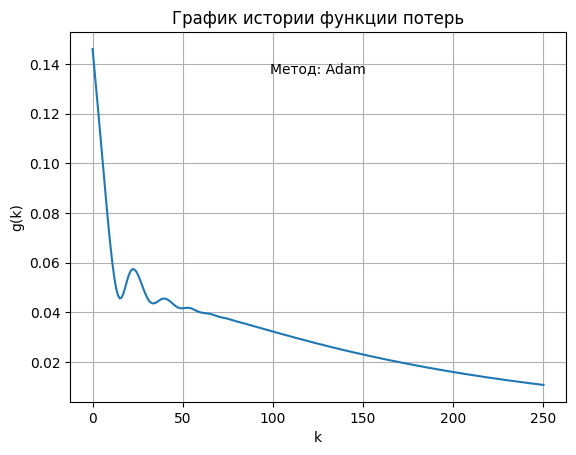

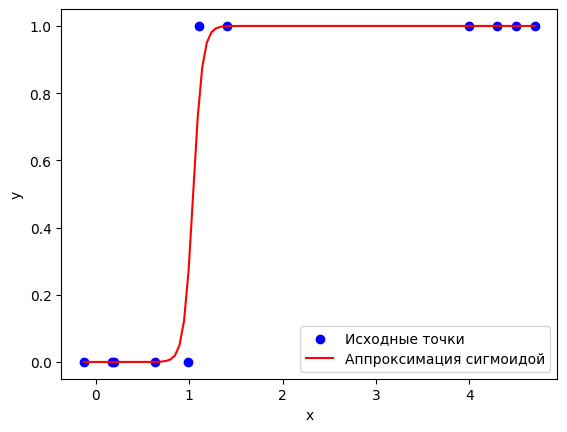

[ 1.         -0.12945952]


In [3]:
# load in data 
import autograd.numpy as np
from jax import grad, hessian
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import mpmath



csvname = datapath + '2d_classification_data_v1_entropy.csv'
data = np.loadtxt(csvname,delimiter = ',')


class LinearClass(LinearReg):
    
    def __init__(self, X, Y, w0, lamb=0):
        self.X = np.column_stack((np.ones(len(X.T)), X.T))
        self.Y = Y[0]
        self.w0 = jnp.array(w0)
        self.w, self.w_history, self.method = None, None, None
        self.lamb = lamb

    def sigma(self, arg):
        return 1 / (1 + jnp.exp(-arg))

    def RMS(self, w):
        return jnp.mean((self.sigma(self.linear_model(jnp.stack(self.X), w)) - self.Y)**2)

    def predict(self, x):
        x = jnp.array(x, dtype=jnp.float64)
        ones = jnp.ones((x.shape[0], 1), dtype=jnp.float64)
        conc = jnp.concatenate((ones, x), axis=1)
        weight = self.w0 if self.w is None else self.w
        calc_lin = self.linear_model(conc, weight)
        return jnp.where(jnp.unique(self.Y)[0], jnp.tanh(calc_lin), self.sigma(calc_lin)) if not self.loss.__name__ == "ReLU" else calc_lin

    def set_function_loss(self, fun):
        if fun == "RMS":
            self.method, self.loss = self.RMS, self.RMS
        elif fun == "MAD":
            self.method, self.loss = self.MAD, self.MAD
        elif fun == "Cross_entropy":
            self.method, self.loss = self.cross_entropy, self.cross_entropy
        elif fun == "soft_max_log":
            self.method, self.loss = self.soft_max_log, self.soft_max_log
        elif fun == "soft_max":
            self.method, self.loss = self.soft_max, self.soft_max
        elif fun == "ReLU":
            self.method, self.loss = self.ReLU, self.ReLU
        else:
            raise TypeError("Invalid loss function specified")

        return f"Current function of loss {fun}"

    def cross_entropy(self, w):
        eps = 1e-15
        ones_vector = jnp.ones_like(self.Y)
        eps_vector = eps*ones_vector
        left = self.Y*jnp.log(eps_vector + self.sigma(self.linear_model(jnp.stack(self.X), w)))  
        right = jnp.nan_to_num((ones_vector - self.Y)*jnp.log(eps_vector + ones_vector - self.sigma(self.linear_model(jnp.stack(self.X), w))), nan=-0.0) 
        return -jnp.mean(self.Y*left + right)

    def soft_max(self, w):
        ones_vector = jnp.ones_like(self.Y)
        log_terms = jnp.log(ones_vector + jnp.exp(-self.Y*self.linear_model(jnp.stack(self.X), w))) + self.lamb*jnp.linalg.norm(w)**2
        return jnp.mean(log_terms)

    def soft_max_log(self, w):
        positive_mask = self.Y > 0
        negative_mask = self.Y < 0
        positive_terms = -jnp.log(self.sigma(self.linear_model(self.X[positive_mask], w)))
        negative_terms = -jnp.log(1 - self.sigma(self.linear_model(self.X[negative_mask], w)))
        s = jnp.sum(positive_terms) + jnp.sum(negative_terms)
        return s / len(self.Y)

    def ReLU(self, w):
        lin_calc = self.linear_model(jnp.stack(self.X), w)
        term = -self.Y*lin_calc
        positive_mask = term > 0
        return jnp.sum(term[positive_mask]) / len(self.Y)

    
    def metrics(self, x):
        pr = self.predict(x)
        if self.loss.__name__ == "cross_entropy":
            pr[pr < 0.5] = 0
            pr[pr >= 0.5] = 1
        else:
            pr = jnp.sign(pr)

        res =  pr - self.Y
        incorrects = jnp.count_nonzero(res)
        accuracy = 1 - incorrects / len(self.Y)
        return f"incorr: {incorrects}\nacc: {accuracy}"
        
                
            
                
                
        
        

    
    




# get input/output pairs
x = data[:-1,:]
y = data[-1:,:]




clsficator = LinearClass(x, y, [-2.0, 5.0])
clsficator.set_function_loss("RMS")
clsficator.Adam(0.1, 250, 0.9, 0.9, loss=True)
x_range = jnp.linspace(jnp.min(x), jnp.max(x), 100)
x_range = jnp.expand_dims(x_range, axis=1)
y_pred = clsficator.predict(x_range)
plt.scatter(x[0], y[0], color='blue', label='Исходные точки')
plt.plot(x_range, y_pred, color='red', label='Аппроксимация сигмоидой')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print(clsficator.X[0])

# Exercise 6.3. Implementing the Cross Entropy cost

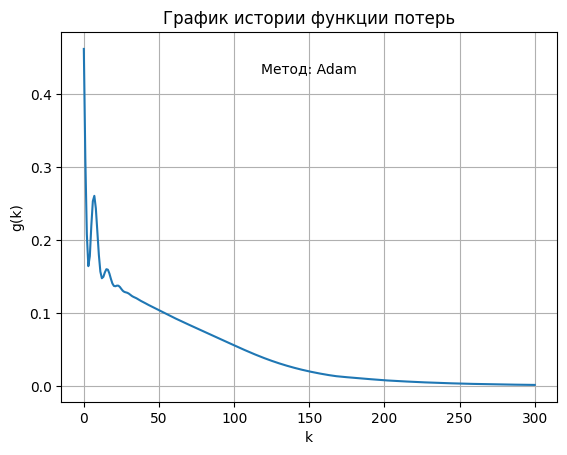

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


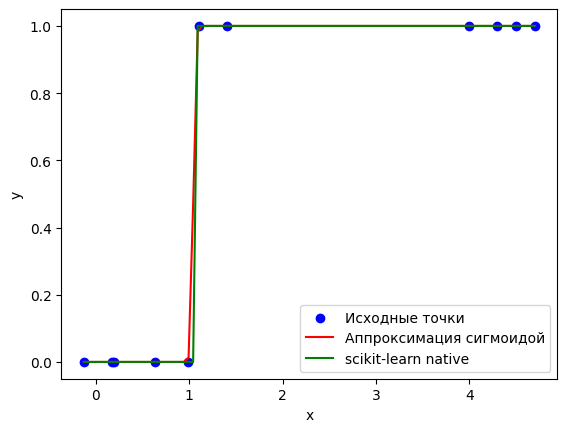

In [4]:
# load in data
from sklearn.linear_model import LogisticRegression
csvname = datapath + '2d_classification_data_v1_entropy.csv'
data = np.loadtxt(csvname,delimiter = ',')

# Создание экземпляра классификатора

# Обучение модели на обучающих данных

# Предсказание классов для тестовых данных

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:]
classifier = LogisticRegression(penalty='none')
classifier.fit(x.reshape(-1, 1), y[0])



clsficator = LinearClass(x, y, [-2.0, 5.0])
clsficator.set_function_loss("Cross_entropy")
clsficator.Adam(0.5, 300, 0.8, 0.9, loss=True)
x_range = jnp.linspace(jnp.min(x), jnp.max(x), 100)
x_range = jnp.expand_dims(x_range, axis=1)
y_pred1 = classifier.predict(np.array(x_range).reshape(-1, 1))
print(y_pred1)
y_pred = clsficator.predict(x_range)
plt.scatter(x[0], y[0], color='blue', label='Исходные точки')
plt.plot(x_range, y_pred, color='red', label='Аппроксимация сигмоидой')
plt.plot(x_range, y_pred1, color='green', label='scikit-learn native')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Exercise 6.7. Implementing the Softmax cost

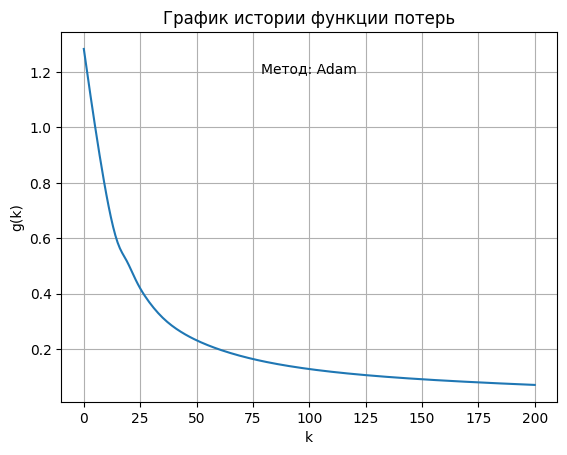

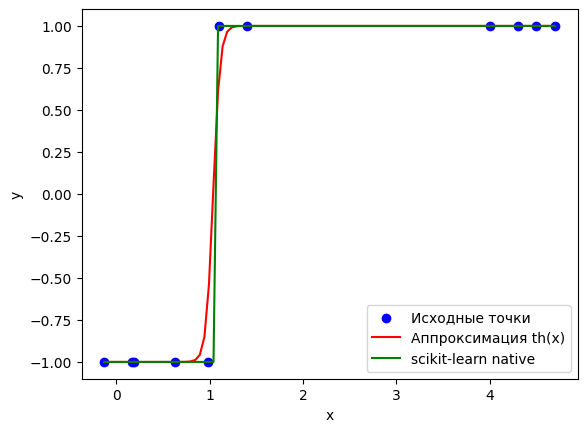

In [5]:
# load in data
csvname = datapath + '2d_classification_data_v1.csv'
data = np.loadtxt(csvname,delimiter = ',')

# take input/output pairs from data
x = data[:-1,:]
y = data[-1:,:] 

classifier = LogisticRegression(penalty='none')
classifier.fit(x.reshape(-1, 1), y[0])
clsficator = LinearClass(x, y, [2.0, 2.0])
clsficator.set_function_loss("soft_max")
clsficator.Adam(0.1, 200, 0.8, 0.9, loss=True)
x_range = jnp.linspace(jnp.min(x), jnp.max(x), 100)
x_range = jnp.expand_dims(x_range, axis=1)
y_pred = clsficator.predict(x_range)
y_pred1 = classifier.predict(np.array(x_range).reshape(-1, 1))
plt.scatter(x[0], y[0], color='blue', label='Исходные точки')
plt.plot(x_range, y_pred, color='red', label='Аппроксимация th(x)')
plt.plot(x_range, y_pred1, color='green', label='scikit-learn native')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Exercise 6.8. Implementing the Log Error version of Softmax

In [6]:
x = [[2, 3], [4, 5]]
ones = [1, 1]
list(zip(ones, x))

[(1, [2, 3]), (1, [4, 5])]

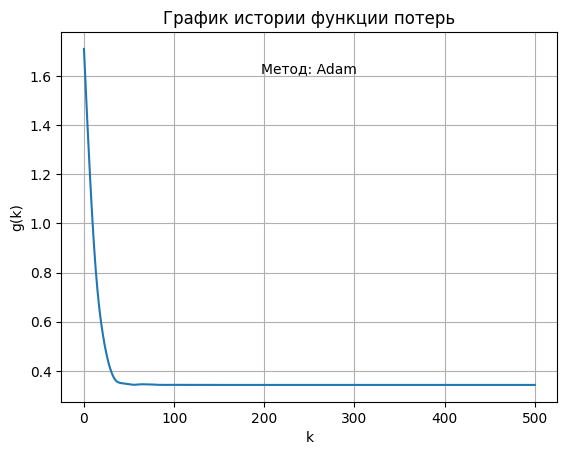

Best C: 2
Best score: 0.9306122448979594
incorr: 5
acc: 0.949999988079071
[-0.66370772  2.33889826 -2.21937311]


In [7]:
# load in dataset
from sklearn.model_selection import GridSearchCV


csvname = datapath + '3d_classification_data_v0.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 


classifier = LogisticRegression()
param_grid = {'C': [1, 2, 3, 4, 5]}

# Создаем объект GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=7)

# Обучаем модель с использованием GridSearchCV
grid_search.fit(x.T, y.ravel())
clsficator = LinearClass(x, y, [1.0, 2.0, 2.0])
clsficator.set_function_loss("soft_max")
clsficator.Adam(0.1, 500, 0.9, 0.9, loss=True)
print("Best C:", grid_search.best_params_['C'])
print("Best score:", grid_search.best_score_)
print(clsficator.metrics(x.T))
print(clsficator.w)

# Exercise 6.9. Using gradient descent to minimize the Perceptron cost

(2, 100)
(1, 100)


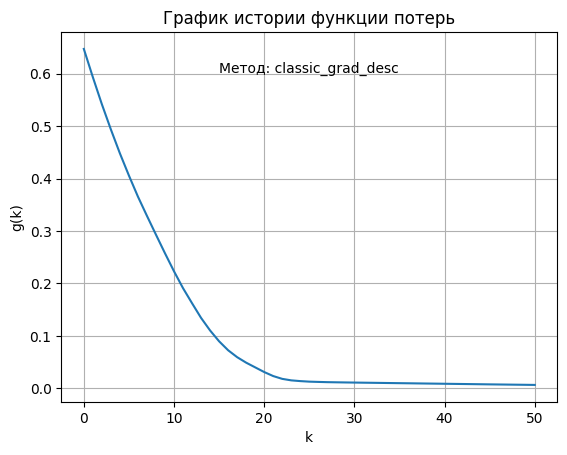

incorr: 6
acc: 0.9399999976158142
[-0.02832915  0.10460192 -0.0961852 ]
4


In [11]:
# load in dataset
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression


csvname = datapath + '3d_classification_data_v0.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

print(np.shape(x))
print(np.shape(y))
classifier = SGDClassifier(learning_rate='adaptive', eta0=0.1)
classifier.fit(x.T, y.ravel())
weights = np.random.uniform(low=-2, high=0, size=3)
clsficator = LinearClass(x, y, weights)
clsficator.set_function_loss("ReLU")
clsficator.gradient_descent(0.1, 50, loss=True)
print(clsficator.metrics(x.T))
print(clsficator.w)
print(jnp.count_nonzero(classifier.predict(x.T) - y))


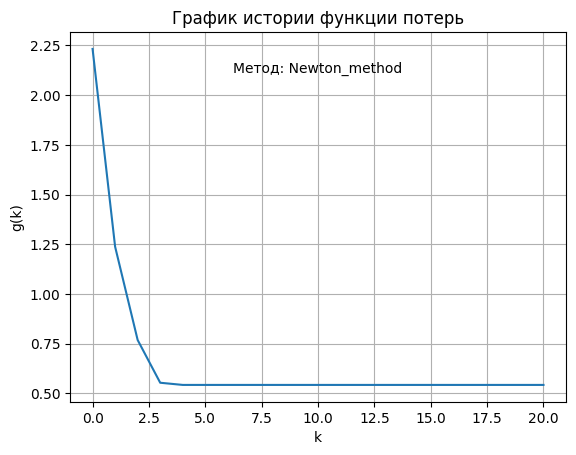

{'min': (Array([-0.17795861,  0.62080698, -0.5281151 ], dtype=float64),
  0.5424301227890288),
 'weights_history': [Array([-1.01682417, -1.56582738, -1.94358322], dtype=float64),
  Array([0.15882652, 1.86369475, 0.5655426 ], dtype=float64),
  Array([-0.27355354, -0.09605434, -1.04484259], dtype=float64),
  Array([-0.14941024,  0.73417598, -0.37431413], dtype=float64),
  Array([-0.17685974,  0.61660455, -0.52904281], dtype=float64),
  Array([-0.1779575 ,  0.62080462, -0.52811469], dtype=float64),
  Array([-0.17795861,  0.62080698, -0.5281151 ], dtype=float64),
  Array([-0.17795861,  0.62080698, -0.5281151 ], dtype=float64),
  Array([-0.17795861,  0.62080698, -0.5281151 ], dtype=float64),
  Array([-0.17795861,  0.62080698, -0.5281151 ], dtype=float64),
  Array([-0.17795861,  0.62080698, -0.5281151 ], dtype=float64),
  Array([-0.17795861,  0.62080698, -0.5281151 ], dtype=float64),
  Array([-0.17795861,  0.62080698, -0.5281151 ], dtype=float64),
  Array([-0.17795861,  0.62080698, -0.528115

In [12]:
weights = np.random.uniform(low=-2, high=-1, size=3)
clsficator = LinearClass(x, y, weights, lamb=0.1)
clsficator.set_function_loss("soft_max")
clsficator.Newton(20, loss=True)

# Exercise 6.13. Compare the efficacy of two-class cost functions I

Below we load in the breast cancer dataset -  [a description of which you can find here](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)).  The input datapoints are stacked *column-wise* in this dataset, with the final row being the label of each point.

(8, 699)
(1, 699)


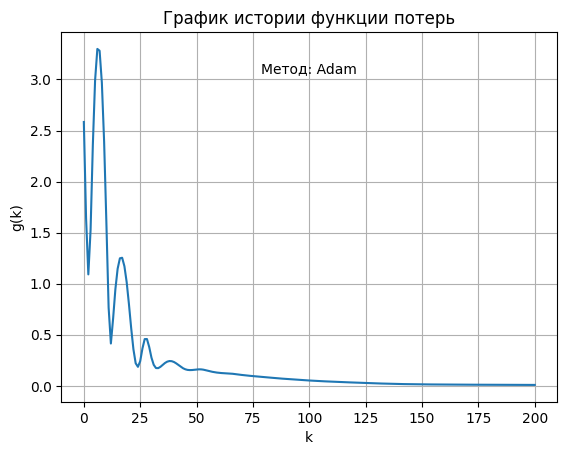

incorr: 26
acc: 0.9628040194511414
[ 1.54021483 -0.1051669  -0.01635501 -0.03291753 -0.04590302 -0.02775275
 -0.10342834 -0.01407257 -0.10421536]
31


In [18]:
# data input
csvname = datapath + 'breast_cancer_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input and output of dataset
x = data[:-1,:]
y = data[-1:,:] 

print(np.shape(x))
print(np.shape(y))
classifier = SGDClassifier(learning_rate="optimal", eta0=0.1, penalty="l1")

# Создаем объект GridSearchCV

classifier.fit(x.T, y.ravel())
weights = np.random.uniform(low=1, high=-1, size=9)
clsficator = LinearClass(x, y, weights, lamb=0.1)
clsficator.set_function_loss("ReLU")
clsficator.Adam(0.1, 200, 0.9, 0.999, loss=True)
print(clsficator.metrics(x.T))
print(clsficator.w)
print(jnp.count_nonzero(classifier.predict(x.T) - y)) #вывод от гтовой библиотеки scikit-learn

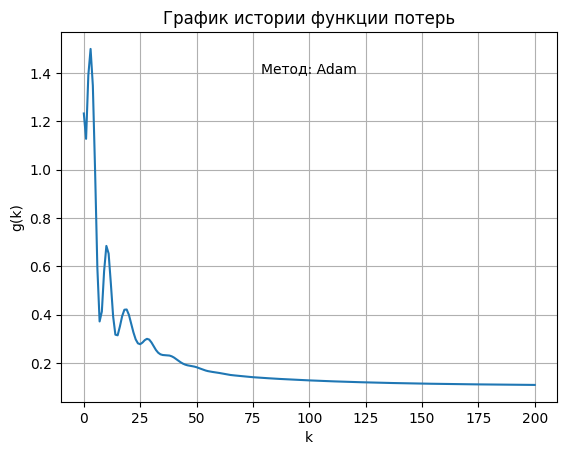

incorr: 26
acc: 0.9628040194511414


In [24]:
weights = np.random.uniform(low=1, high=-1, size=9)
clsficator = LinearClass(x, y, weights)
clsficator.set_function_loss("soft_max")
clsficator.Adam(0.1, 200, 0.9, 0.999, loss=True)
print(clsficator.metrics(x.T))


#soft_max чуть лучше. Остальные прогоны протестил, тоже самое. Он +- меньше неверных классификаций даёт

# Exercise 6.14. Compare the efficacy of two-class cost functions II

Below we load in a spam email dataset -  [a description of which you can find here](https://archive.ics.uci.edu/ml/datasets/Spambase).  The input datapoints are stacked *column-wise* in this dataset, with the final row being the label of each point.

(57, 4601)
(1, 4601)
(57, 4601)
[[1790  998]
 [  37 1776]] 0.775048902412519


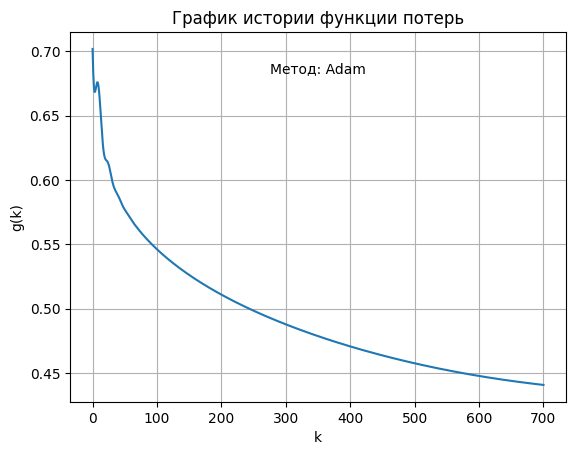

incorr: 771
acc: 0.8324277400970459
[-0.66162316  0.02792238 -0.59190858 -0.43214163  1.84080157  0.28484901
  0.77814957  3.48073876  1.46210523  1.37611041  0.03193352  1.74147334
 -1.7779457   0.26770103 -0.09626189  1.80992659  2.22185923  2.61121324
  0.68404582 -0.31308785  2.01819776  0.24973367  2.05378286  2.84485921
  1.08402045 -4.98377821 -3.39463099 -2.36931322 -0.93210805 -0.84892236
 -0.94948353  0.01425136  0.78489838 -1.61580837  0.70945324 -0.98251582
 -0.01510565 -1.5785845  -0.1635605  -1.43242934  1.03728565 -0.24835903
 -2.47735253 -0.6776223  -2.03291405 -2.87915381 -4.17542872  0.82263465
 -0.32505723  0.69838509 -1.44285913  0.09599441  0.79646149  2.68178296
  1.6987486  -2.21933611  0.60148215  0.00500086]


In [25]:
# data input

from sklearn.svm import LinearSVC

csvname = datapath + 'spambase_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

# get input and output of dataset
x = data[:-1,:]
y = data[-1:,:]

print(np.shape(x))
print(np.shape(y))

scaler = StandardScaler()
normalized_data = scaler.fit_transform(x)
print(np.shape(normalized_data))
classifier = LinearSVC(C=10000, dual=False, penalty="l2", max_iter=100000, loss="squared_hinge")
classifier.fit(normalized_data.T, y.ravel())
y_pred = classifier.predict(x.T)
cm = confusion_matrix(y.ravel(), y_pred)
accuracy = accuracy_score(y.ravel(), y_pred)
print(cm, accuracy) #точность на опорных векторах
weights = np.random.uniform(low=-0.1, high=0.1, size=58)
clsficator = LinearClass(normalized_data, y, weights, lamb=10e-5)
clsficator.set_function_loss("soft_max")
clsficator.Adam(0.01, 700, 0.9, 0.99, loss=True)
print(clsficator.metrics(x.T))
print(clsficator.w)

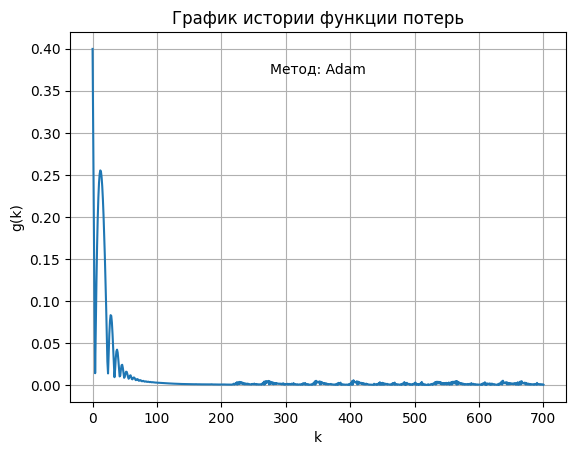

incorr: 2616
acc: 0.4314279556274414
[-0.04399339  0.01095196  0.03435575  0.03299855  0.0816121   0.04097674
  0.0423677   0.14003617  0.05381543  0.05955143  0.0388445   0.08337363
  0.02831921  0.03202442  0.03595797  0.10999497  0.05869687  0.09257343
  0.04061978  0.03712905  0.08461894  0.03917575  0.09097311  0.17545108
  0.04620684 -0.09540799  0.02932886 -0.15641633  0.04224496  0.03162108
 -0.02186738 -0.01427158  0.16726786  0.00230644  0.09373168  0.02627287
  0.03031563  0.02260059  0.02733543  0.00050135  0.07745761  0.04176735
 -0.05622331 -0.01554437 -0.01172428  0.01727599 -0.06468164  0.04971442
  0.0253857  -0.03045324 -0.00365894  0.03306642  0.04222754  0.12339053
  0.14915059  0.02750999  0.04364088  0.04361407]


In [27]:
weights = np.random.uniform(low=-0.1, high=0.1, size=58)
clsficator = LinearClass(normalized_data, y, weights, lamb=10e-5)
clsficator.set_function_loss("ReLU")
clsficator.Adam(0.01, 700, 0.9, 0.99, loss=True)
print(clsficator.metrics(x.T))
print(clsficator.w) #С RElU гораздо хуже Во всех использована микрорегуляризация Для сбалансированного поиска весов

# Exercise 6.15. Credit check

(20, 1000)


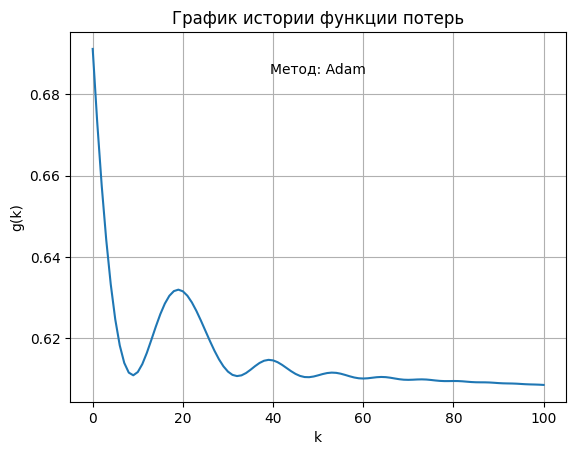

incorr: 300
acc: 0.699999988079071
[ 0.09122491 -0.00651352 -0.34410807 -0.04900874 -0.09162588  0.0898371
 -0.06367153 -0.05632207 -0.12319398 -0.0915148  -0.11594952 -0.10276169
 -0.14764124  0.46280864 -0.08526085 -0.1107901  -0.1056307  -0.10361946
 -0.12693447 -0.10831784 -0.11871281]
[[ 29 271]
 [ 16 684]] 0.713


In [28]:
# load in dataset

from sklearn.svm import SVC


csvname = datapath + 'credit_dataset.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

scaler = StandardScaler()
normalized_data = scaler.fit_transform(x)
print(np.shape(normalized_data))
weights = np.random.uniform(low=--0.01, high=0.01, size=21)
clsficator = LinearClass(normalized_data, y, weights)
clsficator.set_function_loss("soft_max")
clsficator.Adam(0.01, 100, 0.9, 0.9, loss=True)
print(clsficator.metrics(x.T))
print(clsficator.w)
classifier = SGDClassifier(learning_rate="adaptive", eta0=1, penalty="l2") #Здесь градиентный стохастический классификатор лучше всего подошёл 71% макс точность и склонение к неправильному классифицированию положительных случаев
classifier.fit(normalized_data.T, y.ravel())
y_pred = classifier.predict(x.T)
cm = confusion_matrix(y.ravel(), y_pred)
accuracy = accuracy_score(y.ravel(), y_pred)
print(cm, accuracy)

# Exercise 6.16. Weighted classification and balanced accuracy

In [29]:
# data input
csvname = datapath + '3d_classification_data_v2_mbalanced.csv'
data1 = np.loadtxt(csvname,delimiter = ',')

# get input and output of dataset
x = data1[:-1,:]
y = data1[-1:,:] 

print(np.shape(x))
print(np.shape(y))

(2, 55)
(1, 55)


In [30]:
from sklearn.svm import SVC

classifier = SVC(class_weight="balanced") #делаем взвешивание, так как число классов не сбалансированно. SVC здесь лучше всего себя показала

classifier.fit(x.T, y.ravel())
y_pred = classifier.predict(x.T)
accuracy = accuracy_score(y.ravel(), y_pred)
cm = confusion_matrix(y.ravel(), y_pred)
print(cm, accuracy)

[[47  3]
 [ 0  5]] 0.9454545454545454
